# Computation of the quantization process MNIST int8

In [1]:
import tensorflow as tf
import numpy as np
import pathlib
import netron
import matplotlib.pyplot as plt

# Load data

In [2]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (eva_images, eva_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images_float32 = train_images.astype(np.float32) / 255.0
eva_images_float32 = eva_images.astype(np.float32) / 255.0

# Normalize the input image so that each pixel value is between 0 and 255.
train_images_uint8 = train_images.astype(np.uint8)
eva_images_uint8 = eva_images.astype(np.uint8)

# # Normalize the input image so that each pixel value is between -128 and 127.
train_images_int8 = np.int8(train_images.astype(np.float32) - 128.0)
eva_images_int8 = np.int8(eva_images.astype(np.float32) - 128.0)


In [3]:
print(train_images_float32.shape, train_labels.shape)
print(train_images_uint8.shape, train_labels.shape)
print(train_images_int8.shape, train_labels.shape)

(60000, 28, 28) (60000,)
(60000, 28, 28) (60000,)
(60000, 28, 28) (60000,)


In [4]:
print(f'train_images_float32:\n {train_images_float32[0][14]} \n-----------')
print(f'train_images_uint8:\n {train_images_uint8[0][14]} \n-----------')
print(f'train_images_int8:\n {train_images_int8[0][14]} \n-----------')

train_images_float32:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.31764707 0.9411765  0.99215686 0.99215686 0.46666667
 0.09803922 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ] 
-----------
train_images_uint8:
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  81 240 253 253 119
  25   0   0   0   0   0   0   0   0   0] 
-----------
train_images_int8:
 [-128 -128 -128 -128 -128 -128 -128 -128 -128 -128 -128 -128 -128  -47
  112  125  125   -9 -103 -128 -128 -128 -128 -128 -128 -128 -128 -128] 
-----------


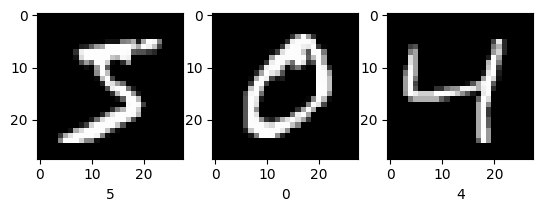

In [5]:
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(train_images_int8[i], cmap="gray")
    plt.xlabel(train_labels[i])
plt.show()

# Reshape data

In [6]:
# image dimensions (assumed square)
image_size = train_images_float32.shape[1]
input_size = image_size * image_size
print(f'image_size: {image_size}, input_size: {input_size}')

#reshape data to fit model
train_images_float32 = np.reshape(train_images_float32, [-1, input_size])
eva_images_float32 = np.reshape(eva_images_float32, [-1, input_size])

train_images_uint8 = np.reshape(train_images_uint8, [-1, input_size])
eva_images_uint8 = np.reshape(eva_images_uint8, [-1, input_size])

train_images_int8 = np.reshape(train_images_int8, [-1, input_size])
eva_images_int8 = np.reshape(eva_images_int8, [-1, input_size])

print(f'train_images_float32.shape: {train_images_float32.shape}')
print(f'train_images_uint8.shape: {train_images_uint8.shape}')
print(f'train_images_int8.shape: {train_images_int8.shape}')

image_size: 28, input_size: 784
train_images_float32.shape: (60000, 784)
train_images_uint8.shape: (60000, 784)
train_images_int8.shape: (60000, 784)


# Crate nn model

In [7]:
# Define a simple sequential model
def create_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_dim=input_size),
    tf.keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
print(model.summary())

model.fit(
    train_images_float32,
    train_labels,
    epochs=10,
    batch_size=64,
    validation_data=(eva_images_float32, eva_labels)
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 [==============================] - 1s 1ms/step - loss: 0.4704 - accuracy: 0.8720 - val_loss: 0.2645 - val_accuracy: 0.9254
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2457 - accuracy: 0.9302 - val_loss: 0.2310 - val_accuracy: 0.9311
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2063 - accuracy: 0.9401 - val_loss: 0.1998 - val_accuracy: 0.9396
Epoch 4/10
938/93

# save float weights

In [8]:
tflite_models_dir = pathlib.Path("models")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

float_weights_path = r"./models/mnist_float_nn_tf/mnist_float_weights"

# Save the model:
float_weights_model_file = tflite_models_dir / "mnist_float_nn_tf/mnist_float_weights"
float_weights_model_file_index = tflite_models_dir / "mnist_float_nn_tf/mnist_float_weights.index"
if not float_weights_model_file_index.is_file():
    model.save_weights(float_weights_model_file)
    print("Float weights saved to: ", float_weights_model_file)


# load float weights

In [9]:
model = create_model()
model.load_weights(float_weights_model_file)

print(model.summary(), '\n-----------------------------------------\n-----------------------------------------\n-----------------------------------------')
first_layer_weights = model.layers[0].get_weights()[0]
first_layer_biases  = model.layers[0].get_weights()[1]
second_layer_weights = model.layers[1].get_weights()[0]
second_layer_biases  = model.layers[1].get_weights()[1]

print(f'first_layer_weights:\n {first_layer_weights} \n-----------')
print(f'first_layer_biases:\n {first_layer_biases} \n-----------\n-----------')
print(f'second_layer_weights:\n {second_layer_weights} \n-----------')
print(f'second_layer_biases:\n {second_layer_biases} \n-----------')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                15700     
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None 
-----------------------------------------
-----------------------------------------
-----------------------------------------
first_layer_weights:
 [[-0.05734742  0.03238516 -0.0131309  ...  0.0538438   0.06947835
  -0.08367986]
 [-0.04574046  0.01396968  0.03617882 ...  0.08624725 -0.00907713
   0.02075221]
 [-0.0462221  -0.01265661 -0.02388771 ...  0.01787594  0.05865231
  -0.02859867]
 ...
 [ 0.08237264  0.05092688 -0.0561528  ...  0

In [10]:
if not pathlib.Path(float_weights_path + r'_details.txt').is_file():

    with open(float_weights_path + r'_details.txt', 'w') as f:
        first_layer_weights = model.layers[0].get_weights()[0]
        first_layer_biases  = model.layers[0].get_weights()[1]
        second_layer_weights = model.layers[1].get_weights()[0]
        second_layer_biases  = model.layers[1].get_weights()[1]

        np.array2string(np.array(first_layer_weights), threshold=np.inf, max_line_width=np.inf, separator=", ")

        f.write(f'first_layer_weights:\n {np.array2string(np.array(first_layer_weights), threshold=np.inf, max_line_width=np.inf, separator=", ")} \n-----------\n')
        f.write(f'first_layer_biases:\n {np.array2string(np.array(first_layer_biases), threshold=np.inf, max_line_width=np.inf, separator=", ")} \n-----------\n-----------\n')
        f.write(f'second_layer_weights:\n {np.array2string(np.array(second_layer_weights), threshold=np.inf, max_line_width=np.inf, separator=", ")} \n-----------\n')
        f.write(f'second_layer_biases:\n {np.array2string(np.array(second_layer_biases), threshold=np.inf, max_line_width=np.inf, separator=", ")} \n-----------\n')

    print('Details saved to: ', float_weights_path + r'_details.txt')

# Find out intermediate layer output

In [11]:
# Define a new model that outputs the intermediate layer
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)

# Get the intermediate output for the entire input dataset
intermediate_output_float32 = intermediate_model.predict(train_images_float32)

1875/1875 [==============================] - 1s 574us/step


In [12]:
outputs_float32 = model.predict(train_images_float32)

1875/1875 [==============================] - 1s 632us/step
(60000, 10)


# Convert nn to int8 quantized model

In [13]:
def representative_data_gen():
    for input_value in train_images_float32:
        yield [input_value]


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Patrik\AppData\Local\Temp\tmpzvj67l7n\assets


d:\dp\dp\code\openvino_notebooks_py37\venv\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


# save q model

In [14]:
tflite_models_dir = pathlib.Path("models")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

model_path = r"models/mnist_int8_tflite_model"

# Save the model:
int8_tflite_model_file = tflite_models_dir / "mnist_int8_tflite_model.tflite"
if not int8_tflite_model_file.is_file():
    int8_tflite_model_file.write_bytes(tflite_model_quant)
    print("Model saved to: ", int8_tflite_model_file)

In [15]:
netron.start(model_path + r'.tflite')

Serving 'models/mnist_int8_tflite_model.tflite' at http://localhost:8080


('localhost', 8080)

# load interpreter

In [16]:
if not pathlib.Path(model_path + r'_details.txt').is_file():

    interpreter_saved_details = tf.lite.Interpreter(model_path=model_path + r'.tflite')
    interpreter_saved_details.allocate_tensors()

    input_index = interpreter_saved_details.get_input_details()[0]["index"]
    output_index = interpreter_saved_details.get_output_details()[0]["index"]
    input_details = interpreter_saved_details.get_input_details()[0]

    test_image = eva_images_float32[0]
    print(eva_labels[0])

    # Check if the input type is quantized, then rescale input data to int8
    if input_details["dtype"] == np.int8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter_saved_details.set_tensor(input_index, test_image)

    # Run inference.
    interpreter_saved_details.invoke()

    # Post-processing: remove batch dimension and find the digit with highest probability.
    output = interpreter_saved_details.get_tensor(output_index)
    digit = np.argmax(output[0])
    print(f'output: {output} \n digit: {digit} \n')

    with open(model_path + r'_details.txt', 'w') as f:
        f.write('Tensor details:\n\n')
        for dict in interpreter_saved_details.get_tensor_details():
            i = dict['index']
            tensor_name = dict['name']
            scales = dict['quantization_parameters']['scales']
            zero_points = dict['quantization_parameters']['zero_points']

            flag_tenstor = True
            try:
                tensor = interpreter_saved_details.tensor(i)()
                tensor_arr = np.array(tensor)
            except:
                flag_tenstor = False

            type = dict['dtype']

            f.write(
                f'{i} {type} {tensor_name} \n scales:\n {scales} \n zero_points:\n {zero_points} \n tensor_shape:\n {tensor.shape}\n tensor:\n '
                f'{np.array2string(tensor_arr, threshold=np.inf, max_line_width=np.inf, separator=", ") if flag_tenstor else "Tensor data is null" }\n')
            f.write(
                '\n\n------------------------------------------------------------------------------------------------------------------------\n\n')

        for item in interpreter_saved_details.get_tensor_details():
            f.write(str(item).replace('{\'name', '\n{\'name'))

    print('Details saved to: ', model_path + r'_details.txt')



# Calculations

In [17]:
tf.quantization.quantize

In [18]:
# Calculation of a, b parameters

def calculation_a_b(input_array):
    return np.min(input_array), np.max(input_array)

############################################################################################################

# Weight quantization

def weight_scaling_factor(a, b, min_T, max_T):
    s_a = a / min_T
    s_b = b / max_T

    if s_a > s_b:
        return s_a, a, max_T * s_a
    else:
        return s_b, min_T * s_b, b

def clamp(r,a,b):
    return min(max(r, a), b)

def weight_quan(r, a, b, min_T, s):

    q_value = np.round((clamp(r,a,b) - a) / s) + min_T

    # print(f'q_value: {q_value}')

    z = 0
    r = s * (q_value - z)

    # print(f'r: {r}')

    return q_value

def weight_arr_quan(input_arr, min_T, max_T):

    a, b = calculation_a_b(input_arr)
    s, a, b = weight_scaling_factor(a, b, min_T, max_T)

    out_arr = np.zeros(input_arr.shape, dtype=np.int8).T

    for i in range(input_arr.shape[0]):
        for j in range(input_arr.shape[1]):
            out_arr[j][i] = weight_quan(input_arr[i][j], a, b, min_T, s)

    return s, 0, out_arr

############################################################################################################

# Activation quantization

def activation_scaling_factor(a, b, n):
   return (b - a) / (n - 1)

def activation_scale_zero_point(input_array, n):
    a, b = calculation_a_b(input_array)
    s = activation_scaling_factor(a, b, n)
    q_value = np.round((0 - a) / s) - n/2
    z = q_value - (0 / s)

    print(f's: {s} \nz: {z}')

    return s, z

def activation_quan(r, a, b, n, s, z):

    q_value = np.round((clamp(r,a,b) - a) / s) - n/2

    print(f'q_value: {q_value}')

    r = s * (q_value - z)
    print(f'r: {r}')

    return q_value

############################################################################################################

# Bias quantization

def bias_quan(r, s_w, s_i):
    return np.round(r / (s_i * s_w))

def bias_arr_quan(arr, s_w, s_i):

    arr = np.array([bias_quan(r, s_w, s_i) for r in arr], dtype=np.int32)
    s = s_w * s_i

    return s, 0, arr

In [19]:
weight_scaling_factor(-0.7989037, 0.7096706, -127, 127)

(0.00629058031496063, -0.7989037, 0.7989037)

In [20]:
weight_quan(0, -0.7989037, 0.7096706, -127, 127)

-127.0

In [21]:
bias_quan(-0.0049962, 0.00392157, 0.01043775)

-122.0

In [22]:
a, b = calculation_a_b(train_images_float32)
print(f'a: {a} b: {b}')

a: 0.0 b: 1.0


In [23]:
arr = [-0.19449125,  0.41917142, -0.16768914, -0.21250191,  0.19403027,  0.38531384, -0.19261985,  0.3959989 , -0.3675089 , -0.27362648]

bias_arr_quan(arr, 0.09114261, 0.01043775)

(0.0009513237775275001,
 0,
 array([-204,  441, -176, -223,  204,  405, -202,  416, -386, -288]))

In [24]:
arr_w = np. array([[-0.14898142,  0.11176224, -0.18184839,  0.01475042, -1.3020742 ,  0.8911642 ,  0.4506968 ,  0.35559794, -0.6825692 ,  0.29967   ],
 [ 0.30354506, -1.2575797 , -0.49922714,  0.09171315,  0.26948544, -0.21767972, -0.05040022,  0.4497028 ,  0.5669265 , -0.02249288],
 [ 0.18492776, -0.41283646, -0.05077624, -0.09359017, -0.0918397 ,  0.25278127,  0.6508589 , -0.62917227,  0.24681503, -1.0154036 ],
 [ 0.28749537, -0.42829025, -0.17855944, -0.263233  , -0.2001618 ,  0.5816766 ,  0.52557003, -0.7747826 , -0.06378494,  0.4804278 ],
 [ 0.38530543,  0.24177484,  0.2786974 , -0.00772023, -0.84185416, -0.5448636 ,  0.46916416, -0.3635583 ,  0.1671324 ,  0.34700316],
 [-0.3061627 ,  0.700827  ,  0.48937836, -0.7005312 ,  0.24280655,  0.06576189,  0.01269353, -0.58230585,  0.46637616,  0.35609108],
 [ 0.40202528,  0.55720055,  0.52929235, -0.43660465,  0.2940682 , -0.42981356,  0.09468375, -0.31770453, -0.5535658 ,  0.5891131 ],
 [ 0.12353495,  0.5655566 , -0.03858546,  0.5065713 , -0.6062107 ,  0.27961892, -0.47189295,  0.10151479,  0.4562366 ,  0.08250338],
 [-0.9581498 ,  0.58648497,  0.6651573 ,  0.5265609 , -0.5867176 , -0.03293226,  0.06797066,  0.49474686, -0.40565455, -0.7732925 ],
 [ 0.0799716 ,  0.3356234 ,  0.1128471 ,  0.25455517, -0.00155973, -0.1851727 ,  0.6763234 ,  0.09741738, -0.6959262 , -1.3255944 ],
 [ 0.14019953, -0.38556352, -1.0292182 , -1.0430739 ,  0.17855032,  0.28404453,  0.5628663 ,  0.26253572, -0.12117667,  0.18916303],
 [ 0.12976398,  0.16296323, -0.01159878,  0.3126462 ,  0.546798  , -1.2633878 , -0.42265695,  0.44269794, -0.05562312,  0.707389  ],
 [-0.5118954 , -0.05814311, -0.32845026,  0.48216608, -0.08906322, -0.23051296, -1.1491957 ,  0.04459784, -0.46486366,  0.5442692 ],
 [-0.5657534 , -0.7050618 ,  0.63420194,  0.22712292,  0.32133728,  0.29722074,  0.28738973, -0.5642939 ,  0.6523944 , -0.20696469],
 [ 0.21137293, -0.3098802 , -0.13420956,  0.31605205,  0.32178643,  0.04884663,  0.05562724, -1.1449679 ,  0.05626617, -0.46083325],
 [-0.1936861 , -0.44014257,  0.4367897 ,  0.400708  , -0.86027527,  0.51569635, -1.0818942 , -0.43304172, -0.23770985, -0.4904236 ],
 [ 0.21535096, -0.45608985, -0.00529958, -0.3071444 ,  0.20741658,  0.53229195, -0.35369784,  0.5564315 , -0.2591222 ,  0.04390877],
 [-0.4020325 ,  0.3596244 ,  0.96913415, -0.29651996,  0.5089108 ,  0.0119906 ,  0.153572  , -0.66312295, -0.6129849 ,  0.578082  ],
 [-0.8628167 ,  0.50079125, -0.40329042, -0.33602753,  0.26502192, -0.4045243 , -0.01535754,  0.4175777 ,  0.24802491, -0.03905395],
 [ 0.40067425, -0.7292119 ,  0.2254473 , -0.2243573 , -0.5358094 , -0.12744993, -0.3729982 ,  0.6164847 , -0.39772326, -0.38605994]])

print(arr_w.shape)

(20, 10)


In [25]:
weight_arr_quan(arr_w, -127, 127)

(0.010437751181102363,
 0,
 array([[ -14,   29,   18,   28,   37,  -29,   39,   12,  -92,    8,   13,
           12,  -49,  -54,   20,  -19,   21,  -39,  -83,   38],
        [  11, -120,  -40,  -41,   23,   67,   53,   54,   56,   32,  -37,
           16,   -6,  -68,  -30,  -42,  -44,   34,   48,  -70],
        [ -17,  -48,   -5,  -17,   27,   47,   51,   -4,   64,   11,  -99,
           -1,  -31,   61,  -13,   42,   -1,   93,  -39,   22],
        [   1,    9,   -9,  -25,   -1,  -67,  -42,   49,   50,   24, -100,
           30,   46,   22,   30,   38,  -29,  -28,  -32,  -21],
        [-125,   26,   -9,  -19,  -81,   23,   28,  -58,  -56,    0,   17,
           52,   -9,   31,   31,  -82,   20,   49,   25,  -51],
        [  85,  -21,   24,   56,  -52,    6,  -41,   27,   -3,  -18,   27,
         -121,  -22,   28,    5,   49,   51,    1,  -39,  -12],
        [  43,   -5,   62,   50,   45,    1,    9,  -45,    7,   65,   54,
          -40, -110,   28,    5, -104,  -34,   15,   -1,  -36],


In [26]:
activation_scale_zero_point(train_images_float32, 256)

s: 0.00392156862745098 
z: -128.0


(0.00392156862745098, -128.0)

In [27]:
intermediate_output_float32.shape

(60000, 20)

In [28]:
activation_scale_zero_point(intermediate_output_float32, 256)

s: 0.09114260206035539 
z: -128.0


(0.09114260206035539, -128.0)

# int8 quantization mnist

In [ ]:
arr_w1 = model.layers[0].get_weights()[0]
arr_b1 = model.layers[0].get_weights()[1]

arr_w2 = model.layers[1].get_weights()[0]
arr_b2 = model.layers[1].get_weights()[1]



In [ ]:
int8_s_w1, int_8s_z1, int8_w1 = weight_arr_quan(arr_w1, -127, 127)

# int4 quantization mnist

# int2 quantization mnist